# 07 - Utility Evaluation

Do unlearning methods preserve model utility? We evaluate on the retain set using:
1. Reconstruction error on marker genes
2. Cell type classification from latent space
3. Latent space visualization (UMAP)
4. Reconstruction error distributions

We compare four models:
- **Baseline**: Original VAE (reference)
- **Fisher**: Information-theoretic unlearning (FAILS privacy but how's utility?)
- **Extra-gradient**: Adversarial co-training (SUCCEEDS at privacy - how's utility?)
- **Retrain**: Gold standard (trained without forget set)

In [2]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import torch
import json
from pathlib import Path
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import umap

from vae import VAE
from utils import set_global_seed, GLOBAL_SEED, DEVICE

set_global_seed(GLOBAL_SEED)
plt.rcParams['figure.figsize'] = (12, 5)

# Paths
DATA_PATH = Path('../data/adata_processed.h5ad')
SPLIT_PATH = Path('../outputs/p1/split_structured.json')
BASELINE_PATH = Path('../outputs/p1/baseline/best_model.pt')
FISHER_PATH = Path('../outputs/p2/fisher_unlearn/fisher_unlearned_model.pt')
EXTRAGRADIENT_PATH = Path('../outputs/p2/adversarial_sweep/extragradient_lambda10_model.pt')
RETRAIN_PATH = Path('../outputs/p1/retrain_structured/best_model.pt')

# Key marker genes for PBMC cell types
MARKER_GENES = {
    'T cells': ['CD3D', 'CD3E'],
    'B cells': ['MS4A1', 'CD79A'],
    'Monocytes': ['CD14', 'LYZ'],
    'NK cells': ['NKG7', 'GNLY']
}

print(f"Device: {DEVICE}")

2025-12-10 23:17:34.457004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Device: cpu


## 1. Load Data and Models

In [3]:
# Load data
adata = sc.read_h5ad(DATA_PATH)
X = torch.FloatTensor(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X)
labels = adata.obs['leiden'].values
gene_names = adata.var_names.tolist()

# Load split
with open(SPLIT_PATH) as f:
    split = json.load(f)
retain_idx = split['retain_indices']
forget_idx = split['forget_indices']

X_retain = X[retain_idx]
labels_retain = labels[retain_idx]

print(f"Retain set: {len(retain_idx)} cells")
print(f"Forget set: {len(forget_idx)} cells")

# Find marker gene indices
marker_indices = {}
for cell_type, genes in MARKER_GENES.items():
    for gene in genes:
        if gene in gene_names:
            marker_indices[gene] = gene_names.index(gene)
print(f"\nFound {len(marker_indices)} marker genes: {list(marker_indices.keys())}")

# V2 architecture config
INPUT_DIM = X.shape[1]
HIDDEN_DIMS = [1024, 512, 128]
LATENT_DIM = 32

def load_model(path, name):
    """Load a VAE model from checkpoint."""
    model = VAE(
        input_dim=INPUT_DIM,
        hidden_dims=HIDDEN_DIMS,
        latent_dim=LATENT_DIM,
        likelihood='nb',
        dropout=0.1,
        use_layer_norm=True
    ).to(DEVICE)
    checkpoint = torch.load(path, map_location=DEVICE)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.eval()
    print(f"Loaded {name}")
    return model

# Load all four models
baseline_model = load_model(BASELINE_PATH, "baseline")
fisher_model = load_model(FISHER_PATH, "fisher")
extragradient_model = load_model(EXTRAGRADIENT_PATH, "extra-gradient")
retrain_model = load_model(RETRAIN_PATH, "retrain")

Retain set: 28094 cells
Forget set: 30 cells

Found 8 marker genes: ['CD3D', 'CD3E', 'MS4A1', 'CD79A', 'CD14', 'LYZ', 'NKG7', 'GNLY']
Loaded baseline
Loaded fisher
Loaded extra-gradient
Loaded retrain


## 2. Helper Functions

In [4]:
def get_latents(model, X, batch_size=512):
    """Extract latent means from model."""
    model.eval()
    latents = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size].to(DEVICE)
            mu, _ = model.encode(batch)
            latents.append(mu.cpu().numpy())
    return np.concatenate(latents, axis=0)

def get_reconstructions(model, X, batch_size=512):
    """Get reconstruction means from model."""
    model.eval()
    recons = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size].to(DEVICE)
            mu, logvar = model.encode(batch)
            z = model.reparameterize(mu, logvar)
            recon_mu, _ = model.decode(z)
            recons.append(recon_mu.cpu().numpy())
    return np.concatenate(recons, axis=0)

def compute_mse_per_gene(X_true, X_recon, gene_indices):
    """Compute MSE for specific genes."""
    mse = {}
    for gene, idx in gene_indices.items():
        mse[gene] = np.mean((X_true[:, idx] - X_recon[:, idx])**2)
    return mse

def classify_from_latents(latents, labels, cv=5):
    """Train logistic regression classifier on latents, return CV accuracy."""
    le = LabelEncoder()
    y = le.fit_transform(labels)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    scores = cross_val_score(clf, latents, y, cv=cv, scoring='accuracy')
    return scores.mean(), scores.std()

## 3. Marker Gene Reconstruction

Do models reconstruct biologically important genes equally well? We compare MSE on key marker genes.

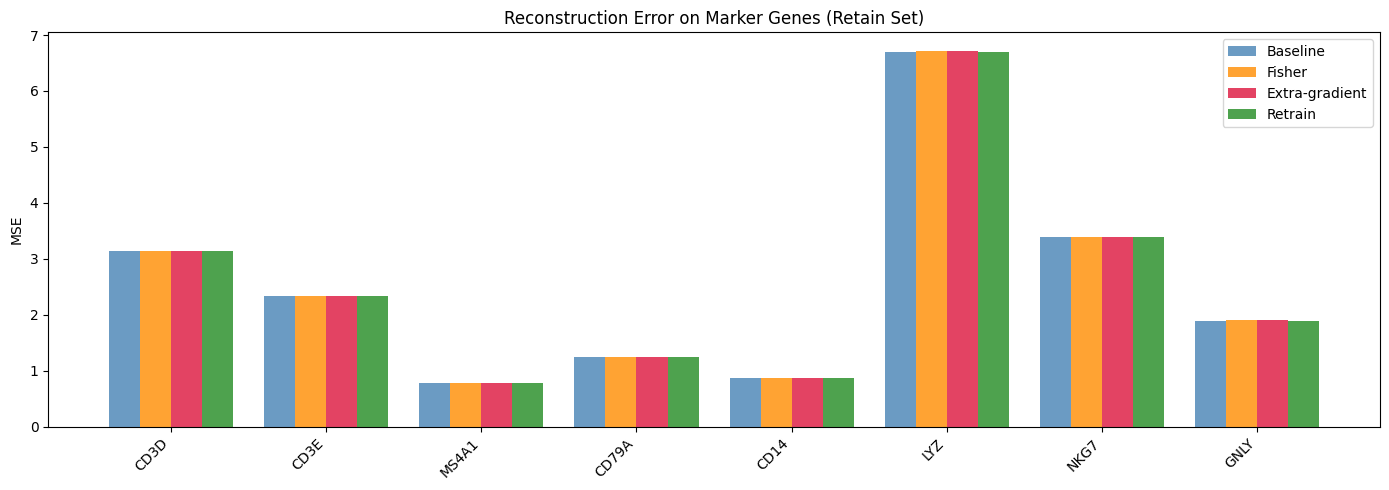


Mean MSE across marker genes:
  Baseline:       2.5409
  Fisher:         2.5465
  Extra-gradient: 2.5439
  Retrain:        2.5408


In [5]:
# Get reconstructions
X_retain_np = X_retain.numpy()
recon_baseline = get_reconstructions(baseline_model, X_retain)
recon_fisher = get_reconstructions(fisher_model, X_retain)
recon_extragradient = get_reconstructions(extragradient_model, X_retain)
recon_retrain = get_reconstructions(retrain_model, X_retain)

# Compute MSE per marker gene
mse_baseline = compute_mse_per_gene(X_retain_np, recon_baseline, marker_indices)
mse_fisher = compute_mse_per_gene(X_retain_np, recon_fisher, marker_indices)
mse_extragradient = compute_mse_per_gene(X_retain_np, recon_extragradient, marker_indices)
mse_retrain = compute_mse_per_gene(X_retain_np, recon_retrain, marker_indices)

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
genes = list(marker_indices.keys())
x = np.arange(len(genes))
width = 0.2

bars1 = ax.bar(x - 1.5*width, [mse_baseline[g] for g in genes], width, label='Baseline', color='steelblue', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, [mse_fisher[g] for g in genes], width, label='Fisher', color='darkorange', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, [mse_extragradient[g] for g in genes], width, label='Extra-gradient', color='crimson', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, [mse_retrain[g] for g in genes], width, label='Retrain', color='forestgreen', alpha=0.8)

ax.set_ylabel('MSE')
ax.set_title('Reconstruction Error on Marker Genes (Retain Set)')
ax.set_xticks(x)
ax.set_xticklabels(genes, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/utility_marker_genes.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary stats
print("\nMean MSE across marker genes:")
print(f"  Baseline:       {np.mean(list(mse_baseline.values())):.4f}")
print(f"  Fisher:         {np.mean(list(mse_fisher.values())):.4f}")
print(f"  Extra-gradient: {np.mean(list(mse_extragradient.values())):.4f}")
print(f"  Retrain:        {np.mean(list(mse_retrain.values())):.4f}")

## 4. Cell Type Classification

Can we still identify cell types from the latent space? We train a logistic regression classifier on latent representations and measure accuracy.

Computing classification accuracy (5-fold CV)...

Cell type classification accuracy:
  Baseline:       0.954 +/- 0.003
  Fisher:         0.818 +/- 0.003
  Extra-gradient: 0.942 +/- 0.002
  Retrain:        0.954 +/- 0.003


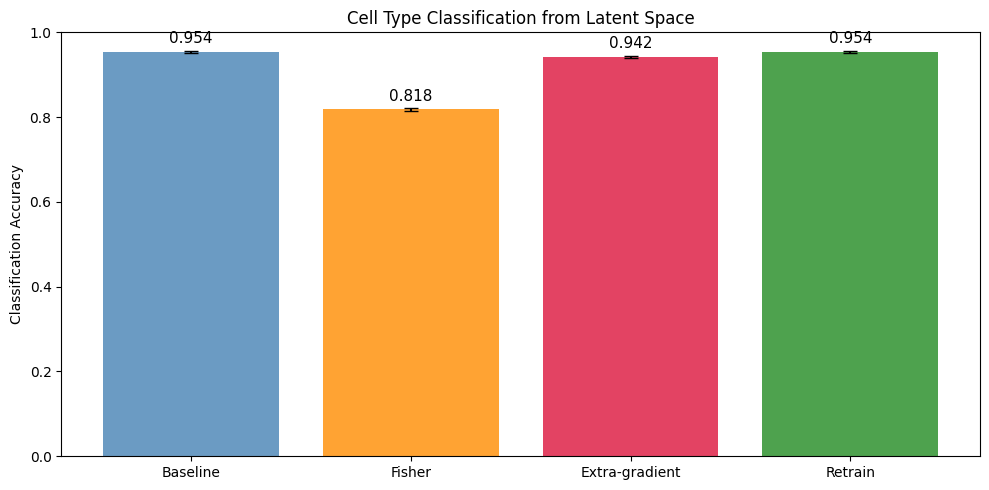

In [6]:
# Extract latents
latents_baseline = get_latents(baseline_model, X_retain)
latents_fisher = get_latents(fisher_model, X_retain)
latents_extragradient = get_latents(extragradient_model, X_retain)
latents_retrain = get_latents(retrain_model, X_retain)

# Cell type classification accuracy
print("Computing classification accuracy (5-fold CV)...")
acc_baseline, std_baseline = classify_from_latents(latents_baseline, labels_retain)
acc_fisher, std_fisher = classify_from_latents(latents_fisher, labels_retain)
acc_extragradient, std_extragradient = classify_from_latents(latents_extragradient, labels_retain)
acc_retrain, std_retrain = classify_from_latents(latents_retrain, labels_retain)

print(f"\nCell type classification accuracy:")
print(f"  Baseline:       {acc_baseline:.3f} +/- {std_baseline:.3f}")
print(f"  Fisher:         {acc_fisher:.3f} +/- {std_fisher:.3f}")
print(f"  Extra-gradient: {acc_extragradient:.3f} +/- {std_extragradient:.3f}")
print(f"  Retrain:        {acc_retrain:.3f} +/- {std_retrain:.3f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
models = ['Baseline', 'Fisher', 'Extra-gradient', 'Retrain']
accs = [acc_baseline, acc_fisher, acc_extragradient, acc_retrain]
stds = [std_baseline, std_fisher, std_extragradient, std_retrain]
colors = ['steelblue', 'darkorange', 'crimson', 'forestgreen']

bars = ax.bar(models, accs, yerr=stds, color=colors, alpha=0.8, capsize=5)
ax.set_ylabel('Classification Accuracy')
ax.set_title('Cell Type Classification from Latent Space')
ax.set_ylim(0, 1)

for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{acc:.3f}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('../reports/figures/utility_classification.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Latent Space Visualization (UMAP)

Visual comparison of cluster structure in the latent space.

Computing UMAP embeddings (this may take a moment)...


/Users/dbenson/.pyenv/versions/stat4243/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


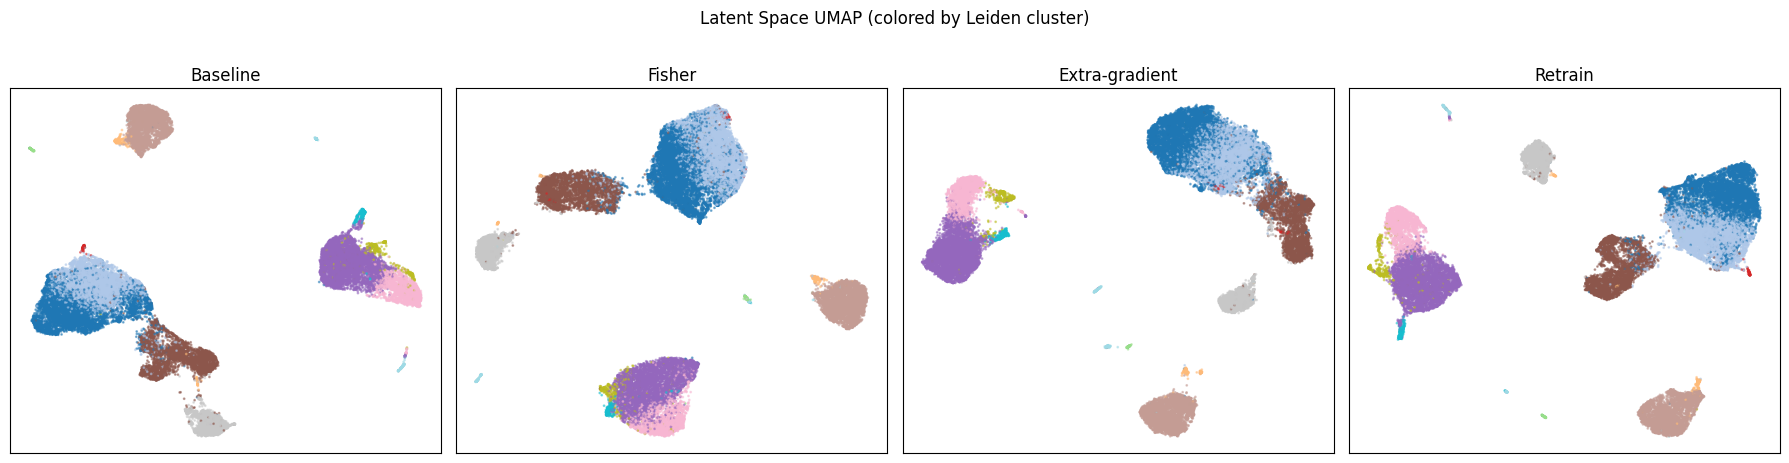

In [7]:
# Compute UMAP embeddings
print("Computing UMAP embeddings (this may take a moment)...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

umap_baseline = reducer.fit_transform(latents_baseline)
umap_fisher = reducer.fit_transform(latents_fisher)
umap_extragradient = reducer.fit_transform(latents_extragradient)
umap_retrain = reducer.fit_transform(latents_retrain)

# Plot
fig, axes = plt.subplots(1, 4, figsize=(18, 4.5))
titles = ['Baseline', 'Fisher', 'Extra-gradient', 'Retrain']
umaps = [umap_baseline, umap_fisher, umap_extragradient, umap_retrain]

for ax, title, emb in zip(axes, titles, umaps):
    scatter = ax.scatter(emb[:, 0], emb[:, 1], c=LabelEncoder().fit_transform(labels_retain), 
                        cmap='tab20', s=1, alpha=0.5)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('Latent Space UMAP (colored by Leiden cluster)', y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/utility_umap.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Reconstruction Error Distribution

Overall reconstruction quality across all genes.

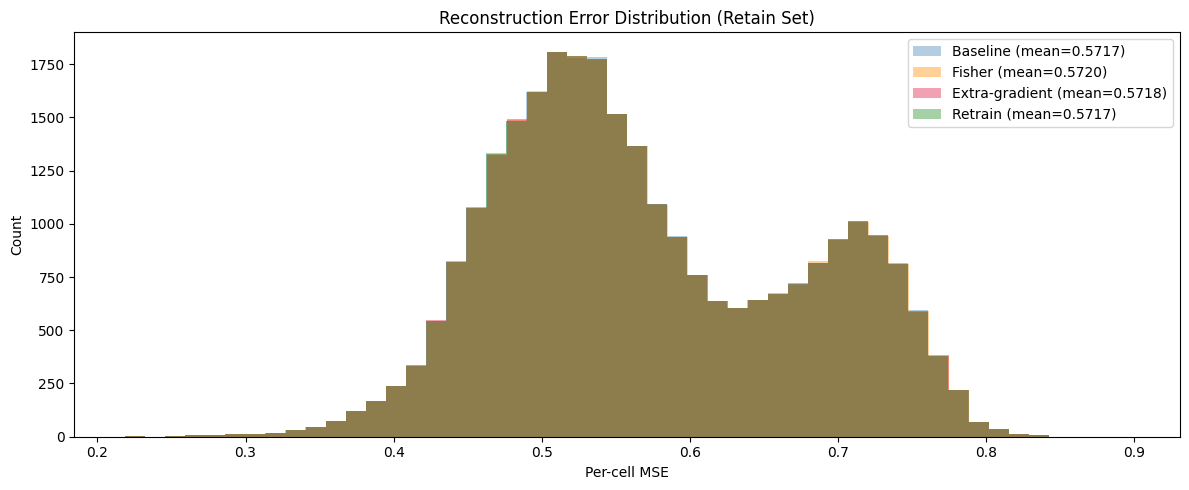


Reconstruction MSE:
  Baseline:       0.5717 +/- 0.1015
  Fisher:         0.5720 +/- 0.1015
  Extra-gradient: 0.5718 +/- 0.1015
  Retrain:        0.5717 +/- 0.1015


In [8]:
# Per-cell MSE
mse_per_cell_baseline = np.mean((X_retain_np - recon_baseline)**2, axis=1)
mse_per_cell_fisher = np.mean((X_retain_np - recon_fisher)**2, axis=1)
mse_per_cell_extragradient = np.mean((X_retain_np - recon_extragradient)**2, axis=1)
mse_per_cell_retrain = np.mean((X_retain_np - recon_retrain)**2, axis=1)

# Plot distributions
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(mse_per_cell_baseline, bins=50, alpha=0.4, label=f'Baseline (mean={np.mean(mse_per_cell_baseline):.4f})', color='steelblue')
ax.hist(mse_per_cell_fisher, bins=50, alpha=0.4, label=f'Fisher (mean={np.mean(mse_per_cell_fisher):.4f})', color='darkorange')
ax.hist(mse_per_cell_extragradient, bins=50, alpha=0.4, label=f'Extra-gradient (mean={np.mean(mse_per_cell_extragradient):.4f})', color='crimson')
ax.hist(mse_per_cell_retrain, bins=50, alpha=0.4, label=f'Retrain (mean={np.mean(mse_per_cell_retrain):.4f})', color='forestgreen')
ax.set_xlabel('Per-cell MSE')
ax.set_ylabel('Count')
ax.set_title('Reconstruction Error Distribution (Retain Set)')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/figures/utility_recon_dist.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nReconstruction MSE:")
print(f"  Baseline:       {np.mean(mse_per_cell_baseline):.4f} +/- {np.std(mse_per_cell_baseline):.4f}")
print(f"  Fisher:         {np.mean(mse_per_cell_fisher):.4f} +/- {np.std(mse_per_cell_fisher):.4f}")
print(f"  Extra-gradient: {np.mean(mse_per_cell_extragradient):.4f} +/- {np.std(mse_per_cell_extragradient):.4f}")
print(f"  Retrain:        {np.mean(mse_per_cell_retrain):.4f} +/- {np.std(mse_per_cell_retrain):.4f}")

## 7. Summary

In [9]:
# Compute summary statistics
marker_mse_baseline = np.mean(list(mse_baseline.values()))
marker_mse_fisher = np.mean(list(mse_fisher.values()))
marker_mse_extragradient = np.mean(list(mse_extragradient.values()))
marker_mse_retrain = np.mean(list(mse_retrain.values()))

recon_mse_baseline = np.mean(mse_per_cell_baseline)
recon_mse_fisher = np.mean(mse_per_cell_fisher)
recon_mse_extragradient = np.mean(mse_per_cell_extragradient)
recon_mse_retrain = np.mean(mse_per_cell_retrain)

# Build summary dataframe
summary_df = pd.DataFrame({
    'Baseline': [marker_mse_baseline, recon_mse_baseline, acc_baseline],
    'Fisher': [marker_mse_fisher, recon_mse_fisher, acc_fisher],
    'Extra-gradient': [marker_mse_extragradient, recon_mse_extragradient, acc_extragradient],
    'Retrain': [marker_mse_retrain, recon_mse_retrain, acc_retrain]
}, index=['Marker gene MSE', 'Overall MSE', 'Classification acc'])

display(summary_df.round(4))

# Relative changes vs Baseline
changes = []
for name, marker, recon, acc, privacy in [
    ('Fisher', marker_mse_fisher, recon_mse_fisher, acc_fisher, 'FAILS'),
    ('Extra-gradient', marker_mse_extragradient, recon_mse_extragradient, acc_extragradient, 'SUCCEEDS'),
    ('Retrain', marker_mse_retrain, recon_mse_retrain, acc_retrain, '(reference)')
]:
    marker_pct = (marker - marker_mse_baseline) / marker_mse_baseline * 100
    recon_pct = (recon - recon_mse_baseline) / recon_mse_baseline * 100
    acc_pct = (acc - acc_baseline) / acc_baseline * 100
    changes.append({
        'Method': name,
        'Marker MSE %': f'{marker_pct:+.1f}%',
        'Overall MSE %': f'{recon_pct:+.1f}%', 
        'Acc %': f'{acc_pct:+.1f}%',
        'Privacy': privacy
    })

print("\nChanges vs Baseline:")
display(pd.DataFrame(changes).set_index('Method'))

,Baseline,Fisher,Extra-gradient,Retrain
Marker gene MSE,2.5409,2.5465,2.5439,2.5408
Overall MSE,0.5717,0.5720,0.5718,0.5717
Classification acc,0.9543,0.8182,0.9423,0.9544



Changes vs Baseline:


,Marker MSE %,Overall MSE %,Acc %,Privacy
Method,,,,
Fisher,+0.2%,+0.1%,-14.3%,FAILS
Extra-gradient,+0.1%,+0.0%,-1.3%,SUCCEEDS
Retrain,-0.0%,-0.0%,+0.0%,(reference)
